<a href="https://www.kaggle.com/code/bigswipp/mayo-image-segmentation?scriptVersionId=103957347" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [52]:
!pip install imutils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import cv2 as cv
from imutils import paths
import skimage
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, regionprops_table
from scipy import ndimage as ndi
import imageio.v2 as imageio
from sklearn.preprocessing import StandardScaler

!pip install imutils

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import cv2 as cv
from imutils import paths
import skimage
from skimage.filters import sobel
from skimage import segmentation
from skimage.color import label2rgb
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity
from skimage.measure import regionprops, regionprops_table
from scipy import ndimage as ndi
import imageio.v2 as imageio
from sklearn.preprocessing import StandardScaler

In [53]:
CE_folder_path = r'../input/mayo-compressed/MAYO/CE'
LAA_folder_path = r'../input/mayo-compressed/MAYO/LAA'

In [54]:
CE_images = sorted(list(paths.list_images(CE_folder_path)))
print('There are ' + str(len(CE_images)) + " images in the CE folder")
CE_images[:5]

There are 547 images in the CE folder


['../input/mayo-compressed/MAYO/CE/006388_0.png',
 '../input/mayo-compressed/MAYO/CE/008e5c_0.png',
 '../input/mayo-compressed/MAYO/CE/026c97_0.png',
 '../input/mayo-compressed/MAYO/CE/029c68_0.png',
 '../input/mayo-compressed/MAYO/CE/032f10_0.png']

In [55]:
LAA_images = sorted(list(paths.list_images(LAA_folder_path)))
print('There are ' + str(len(LAA_images)) + " images in the LAA folder")
LAA_images[:5]

There are 206 images in the LAA folder


['../input/mayo-compressed/MAYO/LAA/00c058_0.png',
 '../input/mayo-compressed/MAYO/LAA/01adc5_0.png',
 '../input/mayo-compressed/MAYO/LAA/028989_0.png',
 '../input/mayo-compressed/MAYO/LAA/03d1ec_0.png',
 '../input/mayo-compressed/MAYO/LAA/055f6a_0.png']

**Opening an Image**

In [56]:
def read_png(path):
    image = imageio.imread(path)
    filename = path.split('/')[-1].rstrip('.png')
    print("image_id: " + filename)
    return image, filename

In [57]:
image, filename = read_png(CE_images[16])
image.shape

image_id: 05a1ec_0


(1024, 642, 3)

**Converting the Image to Grayscale**

In [58]:
def convert_image_grayscale(image):
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    return gray_image

In [59]:
gray_img = convert_image_grayscale(image)

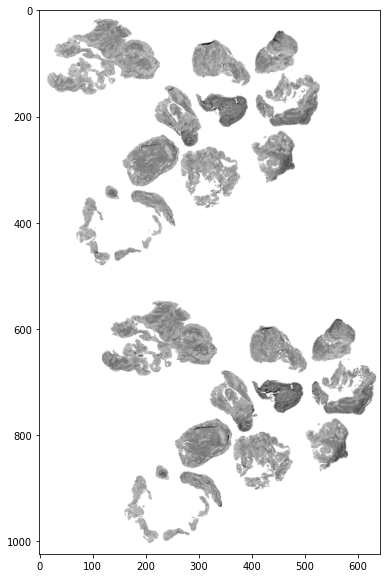

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(gray_img, cmap='gray')
plt.show()

**Image Segmentation**

In [61]:
def segment_images(gray_img):
    elevation_map = sobel(gray_img) # creates image (array) that emphasizes edges
    markers = np.zeros_like(gray_img) # array of zeros in the same shape as the resized_gray_img array
    markers[gray_img >= gray_img.mean()] = 1
    markers[gray_img < gray_img.mean()] = 2
    segmented_img = segmentation.watershed(elevation_map, markers) # distinguishes objects in image 
    filled_segments = ndi.binary_fill_holes(segmented_img - 1) # method works with 0s and 1s (hence the -1, now 1 = area to keep). If 0 is eclosed by 1s -> 0 converted to 1
    labeled_segments, _ = ndi.label(filled_segments) # labels features in array, where non-zero values in input = features, and zero values = background.
    return labeled_segments

In [62]:
labeled_segments = segment_images(gray_img)

In [63]:
def plot_labeled_segments(labeled_segments, gray_img):
    image_label_overlay = label2rgb(labeled_segments, image=gray_img, bg_label=0) # Returns an RGB image where color-coded labels are painted over the image.
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title('segmentation')
    ax.imshow(image_label_overlay, cmap=plt.cm.gray) 
    ax.axis('off')

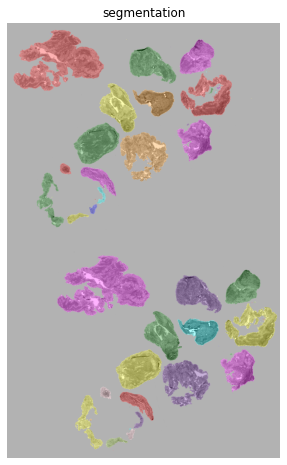

In [64]:
plot_labeled_segments(labeled_segments, gray_img)

**Object Coordinates**

In [65]:
def get_object_coordinates(labeled_segments):
    properties =['area','bbox','convex_area','bbox_area', 'major_axis_length', 'minor_axis_length', 'eccentricity']
    df = pd.DataFrame(regionprops_table(labeled_segments, properties=properties))
    standard_scaler = StandardScaler()
    scaled_area = standard_scaler.fit_transform(df.area.values.reshape(-1,1))
    df['scaled_area'] = scaled_area
    df.sort_values(by="scaled_area", ascending=False, inplace=True)
    objects = df[df['scaled_area']>=.10] # tunable -> the lower it is, the more objects in the image will get boxed (original value = 0.75)
    display(objects.head())
    object_coordinates = [(row['bbox-0'],row['bbox-1'],row['bbox-2'],row['bbox-3'] )for index, row in objects.iterrows()]
    return object_coordinates

In [66]:
object_coordinates = get_object_coordinates(labeled_segments)

,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity,scaled_area
43,17477,547,118,689,336,22292,30956,210.461082,131.062741,0.782428,4.685262
0,16568,16,15,160,228,21667,30672,207.670271,130.599282,0.777504,4.414905
26,7759,257,266,373,379,9783,13108,116.919762,106.307572,0.416283,1.794911
65,7669,794,365,904,478,9364,12430,114.846522,102.432158,0.452223,1.768143
52,6929,660,513,763,635,9607,12566,127.606310,98.737749,0.633468,1.548051


In [67]:
def plot_object_coordinates(object_coordinates, image):
    fig, ax = plt.subplots(1,1, figsize=(18, 16), dpi = 80)
    for blob in object_coordinates:
        width = blob[3] - blob[1]
        height = blob[2] - blob[0]
        patch = Rectangle((blob[1],blob[0]), width, height, edgecolor='r', facecolor='none')
        ax.add_patch(patch)
        ax.imshow(image);
        ax.set_axis_off()

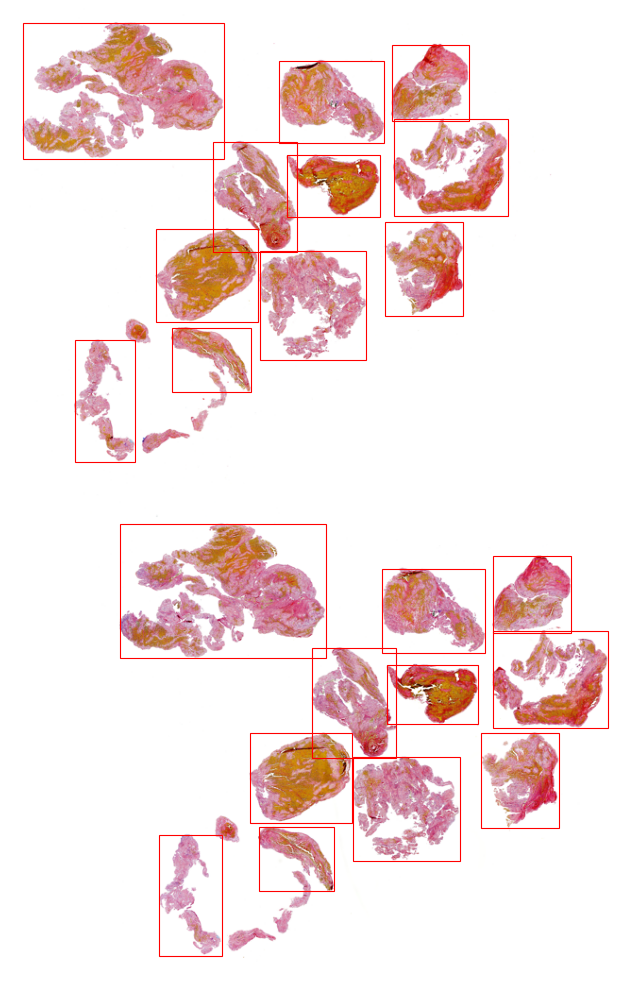

In [68]:
plot_object_coordinates(object_coordinates, image)

**Display Patches**

In [69]:
def plot_objects(object_coordinates, image):
    plt.figure(figsize=(10,18))
    for i in range(len(object_coordinates)):
        ax = plt.subplot(int(np.ceil(len(object_coordinates)/3)),3,i+1)
        coordinates = object_coordinates[i]
        # print(coordinates)
        object_image = image[int(coordinates[0]):int(coordinates[2]), int(coordinates[1]):int(coordinates[3])]
        plt.imshow(object_image)
        ax.axis('off')
    plt.show()

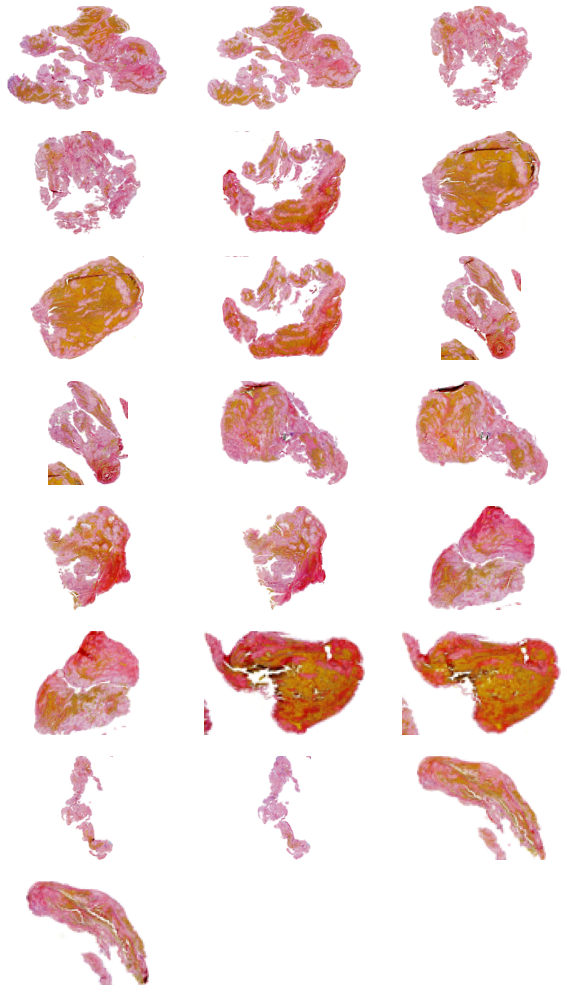

In [70]:
plot_objects(object_coordinates, image)

**Segment table**

In [97]:
def get_dataframe_from_image(path):
    image, file = read_png(path)
    gray_img = convert_image_grayscale(image)
    labeled_segments = segment_images(gray_img)
    df = get_object_coordinates(labeled_segments)
    filename_arr = [file]*len(df)
    print(filename_arr)
    df['Filename'] = filename_arr
    return df

get_dataframe_from_image(CE_images[16])

image_id: 05a1ec_0


,area,bbox-0,bbox-1,bbox-2,bbox-3,convex_area,bbox_area,major_axis_length,minor_axis_length,eccentricity,scaled_area
43,17477,547,118,689,336,22292,30956,210.461082,131.062741,0.782428,4.685262
0,16568,16,15,160,228,21667,30672,207.670271,130.599282,0.777504,4.414905
26,7759,257,266,373,379,9783,13108,116.919762,106.307572,0.416283,1.794911
65,7669,794,365,904,478,9364,12430,114.846522,102.432158,0.452223,1.768143
52,6929,660,513,763,635,9607,12566,127.606310,98.737749,0.633468,1.548051


['05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0', '05a1ec_0']


TypeError: list indices must be integers or slices, not str